In [1]:
###loading
import time
import numpy as np
import matplotlib.pyplot as plt

In [2]:
sig=np.load("./m1_testmbh.npy")
# snr=np.load("./snr.npy")
sig.shape

FileNotFoundError: [Errno 2] No such file or directory: './m1_testmbh.npy'

In [3]:
tmax =  3*24*60*60                 # Final time

fs = 2*1e-3                     # Sampling rate
delta_t = 5
t = np.arange(0,tmax,delta_t)     # Form time vector from t0 = 0 to t_{n-1} = tmax. Length N [include t = zero]

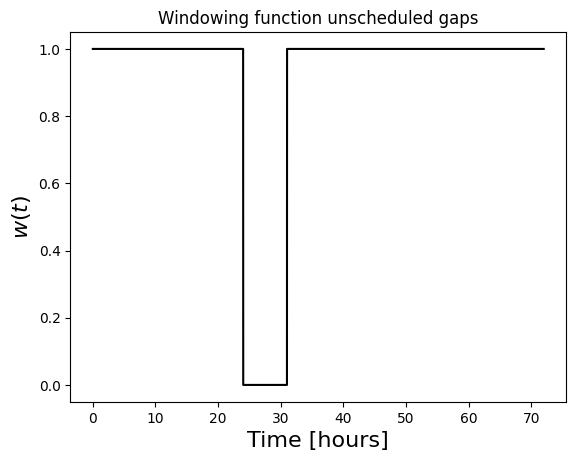

In [4]:
# Set the lambda parameter for the exponential distribution
lambda_value = 0.75
def ge_unsche(t):
    w = np.ones(int(np.random.exponential(scale=1/lambda_value))*24*60*12)
    while len(w) <= len(t):
        durations = int(np.random.uniform(4,8))*60*60
        tt = np.zeros(int(durations/delta_t)) 
        w = np.append(w, tt)
        w = np.append(w, np.ones(int(np.random.exponential(scale=1/lambda_value))*24*60*12))
    return w[:len(t)]

unscheduled_gap=ge_unsche(t)

# Plot the signal

plt.plot(t/60/60,unscheduled_gap, label = "window function unschedule", c = 'black')
plt.xlabel(r'Time [hours]', fontsize = 16)
plt.ylabel(r'$w(t)$', fontsize = 16)
plt.title(r'Windowing function unscheduled gaps')
plt.show()

In [6]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset,DataLoader,random_split

original_data = torch.from_numpy(sig)
original_data=original_data.unsqueeze(1)
print(original_data.size())

del sig

torch.Size([1000, 1, 51840])


In [7]:
### define dataset
class GenDataset(Dataset):
    def __init__(self, data):
        self.data = data

    def __len__(self):
        return len(self.data)

    def __getitem__(self, index):
        sample = self.data[index]
        return sample


In [8]:
normalized_data=GenDataset(original_data.float())
# normalized_data = transform(normalized_datao)
# # Define the sizes of the training and test subsets
train_size = int(0.8 * len(normalized_data))  # 80% for training
test_size = len(normalized_data) - train_size  # Remaining 20% for testing

# Split the dataset randomly
n_train_dataset, n_test_dataset = random_split(normalized_data, [train_size, test_size])

In [9]:
train_dataloader = DataLoader(n_train_dataset, batch_size=50)
test_dataloader = DataLoader(n_test_dataset , batch_size=50)

In [10]:
class Autoencoder(nn.Module):
    def __init__(self):
        super(Autoencoder, self).__init__()

        # Encoder
        self.encoder = nn.Sequential(
            nn.Conv1d(in_channels=1, out_channels=16, kernel_size=7, stride=1, padding=3),
            nn.LeakyReLU(0.1),
            nn.Conv1d(in_channels=16, out_channels=32, kernel_size=5, stride=4, padding=2),
            nn.LeakyReLU(0.1),
            nn.Conv1d(in_channels=32, out_channels=64, kernel_size=3, stride=8, padding=1),
            nn.LeakyReLU(0.1),
            nn.Flatten()
        )
        
        # Linear section
        self.encoder_lin = nn.Sequential(
            nn.Linear(103680, 4096),
            nn.LeakyReLU(0.1),
            nn.Linear(4096, 1024)
        )
        
        self.decoder_lin = nn.Sequential(
            nn.Linear(1024, 4096),
            nn.LeakyReLU(0.1),
            nn.Linear(4096, 103680),
            nn.LeakyReLU(0.1)
        )
        
        self.unflatten = nn.Unflatten(1, torch.Size([64,1620]))
        
        

        # Decoder
        self.decoder = nn.Sequential(
            nn.ConvTranspose1d(in_channels=64, out_channels=32, kernel_size=3, stride=8, padding=1,output_padding=7),
            nn.LeakyReLU(0.1),
            nn.ConvTranspose1d(in_channels=32, out_channels=16, kernel_size=5, stride=4, padding=2,output_padding=3),
            nn.LeakyReLU(0.1),
            nn.ConvTranspose1d(in_channels=16, out_channels=1, kernel_size=7, stride=1, padding=3)
        )
    
    def signal_preprocess(self,x,mask):
        index=mask!=0
        mean= torch.mean(x[:,:,index],dim=(2))  # Compute mean along the dimensions
        std = torch.std(x[:,:,index], dim=(2))  # Compute standard deviation along the dimensions
        normalized_dataset = (x - mean.unsqueeze(2)) / std.unsqueeze(2)  # Normalize the tensor
        cornormalized_dataset = normalized_dataset * mask.reshape((1,1,-1))
        cornormalized_dataset = normalized_dataset.float()
        return cornormalized_dataset,normalized_dataset,mean,std
    
    def signal_backprocess(self,x,mean,std):
        recover=x*std+mean
        return recover

    def forward(self, x):
        # standardize the input
#         nx,mean,std=self.signal_preprocess(x)
        # Encode the input
        encoded = self.encoder(x)
        encoded = self.encoder_lin(encoded)
        
#         print(encoded.size())
        

        # Decode the encoded representation
        decoded = self.decoder_lin(encoded)
        decoded = self.unflatten(decoded)
        decoded = self.decoder(decoded)

        return decoded


# Create an instance of the autoencoder
autoencoder = Autoencoder()

# Print the autoencoder architecture
print(autoencoder)

Autoencoder(
  (encoder): Sequential(
    (0): Conv1d(1, 16, kernel_size=(7,), stride=(1,), padding=(3,))
    (1): LeakyReLU(negative_slope=0.1)
    (2): Conv1d(16, 32, kernel_size=(5,), stride=(4,), padding=(2,))
    (3): LeakyReLU(negative_slope=0.1)
    (4): Conv1d(32, 64, kernel_size=(3,), stride=(8,), padding=(1,))
    (5): LeakyReLU(negative_slope=0.1)
    (6): Flatten(start_dim=1, end_dim=-1)
  )
  (encoder_lin): Sequential(
    (0): Linear(in_features=103680, out_features=4096, bias=True)
    (1): LeakyReLU(negative_slope=0.1)
    (2): Linear(in_features=4096, out_features=1024, bias=True)
  )
  (decoder_lin): Sequential(
    (0): Linear(in_features=1024, out_features=4096, bias=True)
    (1): LeakyReLU(negative_slope=0.1)
    (2): Linear(in_features=4096, out_features=103680, bias=True)
    (3): LeakyReLU(negative_slope=0.1)
  )
  (unflatten): Unflatten(dim=1, unflattened_size=torch.Size([64, 1620]))
  (decoder): Sequential(
    (0): ConvTranspose1d(64, 32, kernel_size=(3,), s

In [11]:
### Define the loss function
loss_fn = torch.nn.MSELoss()

### Define an optimizer (both for the encoder and the decoder!)
lr= 0.00001

### Set the random seed for reproducible results
torch.manual_seed(123)

optim = torch.optim.Adam(autoencoder.parameters(), lr=lr, weight_decay=1e-05)

In [12]:
# train round
total_train_step = 0
# test round
total_test_step = 0

epoch = 50
test_loss=np.zeros(50)

for i in range(epoch):
    print("--------the {} repoch ------".format(i+1))

    # train step
    autoencoder.train()  
    for data in train_dataloader:
        mask=ge_unsche(t)
        snodata,normaldata= autoencoder.signal_preprocess(data,mask)[:2]
        outputs=autoencoder(snodata)
        loss = loss_fn(outputs, normaldata)
        # Add L2 regularization for kernel weights
        l2_regularization = torch.tensor(0.)
        for param_name, param in autoencoder.named_parameters():
            if 'weight' in param_name and 'kernel' in param_name:
                l2_regularization += torch.norm(param)
        loss += l2_regularization * 0.001 # Add L2 regularization term

        # optimizer
        optim.zero_grad()
        loss.backward()
        optim.step()

        total_train_step = total_train_step + 1
        if total_train_step % 8 == 0:
            print("train step：{}, loss:{}".format(total_train_step, loss.item()))

    # test
    autoencoder.eval()
    total_test_loss = 0
    with torch.no_grad():
        for data in test_dataloader:
            mask=ge_unsche(t)
            snodata,normaldata= autoencoder.signal_preprocess(data,mask)[:2]
            outputs=autoencoder(snodata)
            loss = loss_fn(outputs, normaldata)

            total_test_loss = total_test_loss + loss.item()

    print("totel_test_Loss：{}".format(total_test_loss/4))
    test_loss[i]=total_test_loss
    total_test_step += 1



print("train+test done")

--------the 1 repoch ------
train step：8, loss:1.060589075088501
train step：16, loss:1.0505753755569458
totel_test_Loss：1.0484079122543335
--------the 2 repoch ------
train step：24, loss:1.022655725479126
train step：32, loss:0.9707677364349365
totel_test_Loss：0.9640261232852936
--------the 3 repoch ------


KeyboardInterrupt: 

In [12]:
a_true = 5e-21
f_true = 1e-3
fdot_true = 1e-8
testsig=a_true *(np.sin((2*np.pi)*(f_true*t + 0.5*fdot_true * t**2)))

In [13]:
maskt=unscheduled_gap
testinput=torch.tensor(testsig.reshape((1,1,-1)))
snodata,normaldata,mean,std= autoencoder.signal_preprocess(testinput,maskt)
outputs=autoencoder(snodata)


In [17]:
recov=autoencoder.signal_backprocess(outputs,mean.unsqueeze(2),std.unsqueeze(2))
recov.size()

torch.Size([1, 1, 51840])

In [18]:
outputarr=recov.detach().numpy()
outputarr=outputarr.reshape((1,-1))

In [14]:
outputarr=outputs.detach().numpy()
outputarr=outputarr.reshape((1,-1))
testsigi=normaldata.detach().numpy()
testsigi=testsigi.reshape((1,-1))

In [15]:
cordata=testsig*maskt

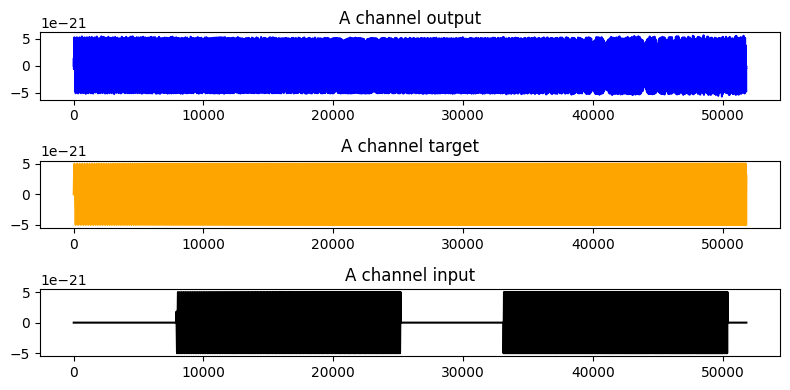

In [19]:

#plot
plt.rcParams["figure.figsize"] = (8,4)

# Create a figure and subplots
fig, axes = plt.subplots(3, 1)

# Plot on the first subplot
axes[0].plot(outputarr[0],c="b")
axes[0].set_title('A channel output')

# Plot on the second subplot
axes[1].plot(testsig,c="orange")
axes[1].set_title('A channel target')

# Plot on the second subplot
axes[2].plot(cordata,c="black")
axes[2].set_title('A channel input')


# Set the layout and display the figure
plt.tight_layout()
plt.show()

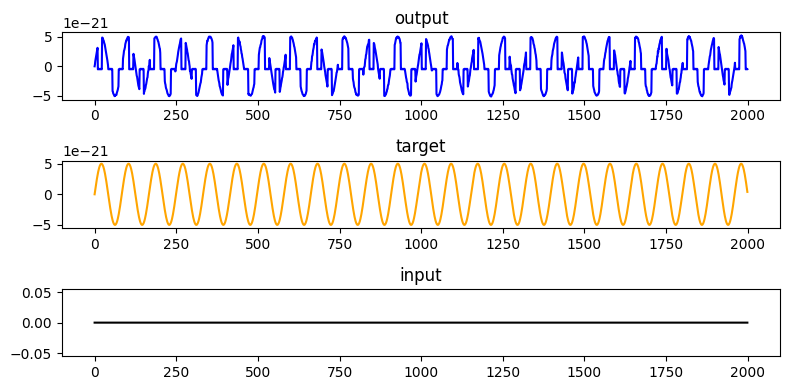

In [23]:

#plot
plt.rcParams["figure.figsize"] = (8,4)
x = np.linspace(0, 2000, 10000)

# Create a figure and subplots
fig, axes = plt.subplots(3, 1)
# y1 = np.ones_like(x)*1.5  # Array of ones with the same shape as x
# y2 = -np.ones_like(x)*1.5  # Array of negative ones with the same shape as x

# Plot on the first subplot
axes[0].plot(outputarr[0][28000:30000],c="b")
# axes[0].plot(x,y1,c="r")
# axes[0].plot(x,y2,c="r")
axes[0].set_title('output')

# Plot on the second subplot
axes[1].plot(testsig[28000:30000],c="orange")
axes[1].set_title('target')

# Plot on the second subplot
axes[2].plot(cordata[28000:30000],c="black")
axes[2].set_title('input')


# Set the layout and display the figure
plt.tight_layout()
plt.show()

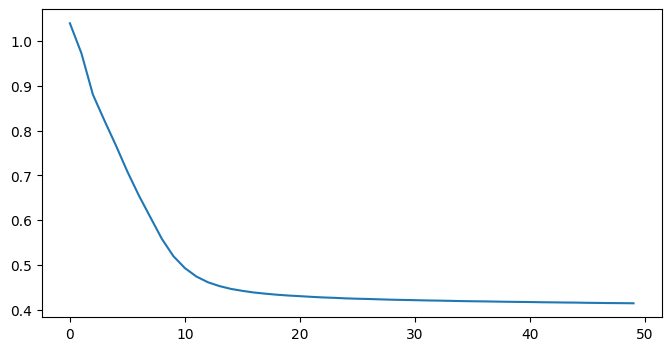

In [25]:
plt.plot(test_loss/4)

In [36]:
torch.save(autoencoder, "./models_aev2_standardized.pth")
print("save model")

save model


In [ ]:
# np.save('output_ae.npy', outputarr[0])
# np.save('target_ae.npy', testinput0[0])
# np.save('input_ae.npy', testinput00[0])


In [ ]:
# torch.save(model.state_dict(), 'model.pth')

In [28]:
# data for rnn
sigrnn=original_data[::5,:,:]
sigrnn.size()

torch.Size([200, 1, 51840])

In [29]:
mask=np.ones(sigrnn.size()[2])
snodata0,normaldata0,mean0,std0= autoencoder.signal_preprocess(sigrnn,mask)
outputs0=autoencoder(snodata0)

inputrnn=outputs0.detach().numpy()
inputrnn=inputrnn.reshape(200,-1)
inputrnn.shape

(200, 51840)

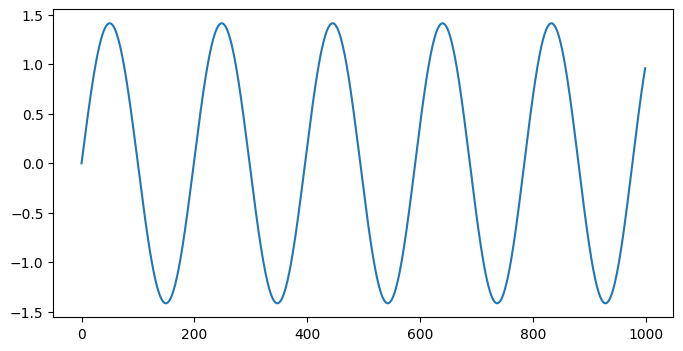

In [33]:
plt.plot(targetrnn[0][:1000])

In [32]:
targetrnn=normaldata0.detach().numpy()
targetrnn=targetrnn.reshape(200,-1)
targetrnn.shape

(200, 51840)

In [34]:
mean0=mean0.detach().numpy()
mean0rnn=mean0.reshape(200,-1)

std0=std0.detach().numpy()
std0rnn=std0.reshape(200,-1)


In [35]:
np.save("../bi_RNN/inputrnn.npy",inputrnn)
np.save("../bi_RNN/targetrnn.npy",targetrnn)
np.save("../bi_RNN/mean0.npy",mean0rnn)
np.save("../bi_RNN/std0.npy",std0rnn)